# Residual analysis to determine the optimal cutoff frequency

> Marcos Duarte, Renato Naville Watanabe  
> [Laboratory of Biomechanics and Motor Control](https://bmclab.pesquisa.ufabc.edu.br)  
> Federal University of ABC, Brazil

A common problem in signal processing is to automatically determine the optimal cutoff frequency that should be employed in a low-pass filter to attenuate as much as possible the noise without compromising the signal content of the data.   

Before we continue, see [this Jupyter notebook](http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DataFiltering.ipynb) for an overview about data filtering if needed.

Unfortunately, there is no definite solution for this problem, but there are some techniques, with different degrees of success, to try to determine the optimal cutoff frequency.  

David Winter, in his classic book *Biomechanics and motor control of human movement*, proposed a method to find the optimal cutoff frequency based on residual analysis of the difference between filtered and unfiltered signals over a range of cutoff frequencies. The optimal cutoff frequency is the one where the residual starts to change very little because it is considered that from this point, it's being filtered mostly noise and minimally signal, ideally. This concept is straightforward to implement.  

The function `optcutfreq.py` from Python module `optcutfreq` is an implementation of this method and it is divided in three parts (after the help section): first, the residuals over a range of cutoff frequencies are calculated; second, an algorithm tries to find the noisy region (with a supposed linear behavior in the frequency domain) of the residuals versus cutoff frequencies plot and finds the optimal cutoff frequency; and third, the results are plotted. The code is lengthy relatively to the simplicity of the idea because of the long help section, the implementation of the automatic search and a rich plot. Here is the function signature:

```python
fc_opt = optcutfreq(y, freq=1, fclim=[], show=False, ax=None):
```

Let's test this function with benchmark data.   

In 1977, Pezzack, Norman and Winter published a paper where they investigated the effects of differentiation and filtering processes on experimental data (the angle of a bar manipulated in space). Since then, these data have became a benchmark to test new algorithms. Let's work with these data (available at [http://isbweb.org/data/pezzack/index.html](http://isbweb.org/data/pezzack/index.html)). The data have the angular displacement measured by video and the angular acceleration  directly measured by an accelerometer, which we will consider as the true acceleration.   
Part of these data are showing next:

In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Installation

```bash
# DEPRECATED: pip install optcutfreq
```

Or

```bash
# DEPRECATED: conda install -c duartexyz optcutfreq
```

In [2]:
#!/usr/bin/env python

"""Automatic search of optimal filter cutoff frequency based on residual analysis."""

import numpy as np
from scipy.signal import butter, filtfilt

__author__ = 'Marcos Duarte, https://github.com/demotu/optcutfreq'
__version__ = "0.0.9"
__license__ = "MIT"


def optcutfreq(y, freq=1, fclim=[], show=False, ax=None):
    """ Automatic search of optimal filter cutoff frequency based on residual analysis.

    This method was proposed by Winter in his book [1]_.
    The 'optimal' cutoff frequency (in the sense that a filter with such cutoff
    frequency removes as much noise as possible without considerably affecting
    the signal) is found by performing a residual analysis of the difference
    between filtered and unfiltered signals over a range of cutoff frequencies.
    The optimal cutoff frequency is the one where the residual starts to change
    very little because it is considered that from this point, it's being
    filtered mostly noise and minimally signal, ideally.

    Parameters
    ----------
    y : 1D array_like
        Data
    freq : float, optional (default = 1)
        sampling frequency of the signal y
    fclim : list with 2 numbers, optional (default = [])
        limit frequencies of the noisy part or the residuals curve
    show : bool, optional (default = False)
        True (1) plots data in a matplotlib figure
        False (0) to not plot
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    fc_opt : float
             optimal cutoff frequency (None if not found)

    Notes
    -----
    A second-order zero-phase digital Butterworth low-pass filter is used.
    # The cutoff frequency is correctyed for the number of passes:
    # C = (2**(1/npasses) - 1)**0.25. C = 0.802 for a dual pass filter. 

    The matplotlib figure with the results will show a plot of the residual
    analysis with the optimal cutoff frequency, a plot with the unfiltered and
    filtered signals at this optimal cutoff frequency (with the RMSE of the
    difference between these two signals), and a plot with the respective
    second derivatives of these signals which should be useful to evaluate
    the quality of the optimal cutoff frequency found.

    Winter should not be blamed for the automatic search algorithm used here.
    The algorithm implemented is just to follow as close as possible Winter's
    suggestion of fitting a regression line to the noisy part of the residuals.

    This function performs well with data where the signal has frequencies
    considerably bellow the Niquist frequency and the noise is predominantly
    white in the higher frequency region.

    If the automatic search fails, the lower and upper frequencies of the noisy
    part of the residuals curve cam be inputed as a parameter (fclim).
    These frequencies can be chosen by viewing the plot of the residuals (enter
    show=True as input parameter when calling this function).


    It is known that this residual analysis algorithm results in oversmoothing
    kinematic data [2]_. Use it with moderation.
    This code is described elsewhere [3]_.

    References
    ----------
    .. [1] Winter DA (2009) Biomechanics and motor control of human movement.
    .. [2] http://www.clinicalgaitanalysis.com/faq/cutoff.html
    .. [3] https://github.com/demotu/optcutfreq/blob/master/docs/optcutfreq.ipynb

    Examples
    --------
    >>> y = np.cumsum(np.random.randn(1000))
    >>> # optimal cutoff frequency based on residual analysis and plot:
    >>> fc_opt = optcutfreq(y, freq=1000, show=True)
    >>> # sane analysis but specifying the frequency limits and plot:
    >>> optcutfreq(y, freq=1000, fclim=[200,400], show=True)
    >>> # It's not always possible to find an optimal cutoff frequency
    >>> # or the one found can be wrong (run this example many times):
    >>> y = np.random.randn(100)
    >>> optcutfreq(y, freq=100, show=True)

    """

    from scipy.interpolate import UnivariateSpline

    # Correct the cutoff frequency for the number of passes in the filter
    C = 0.802  # for dual pass; C = (2**(1/npasses)-1)**0.25

    # signal filtering
    freqs = np.linspace((freq/2) / 100, (freq/2)*C, 101, endpoint=False)
    res = []
    for fc in freqs:
        b, a = butter(2, (fc/C) / (freq / 2))
        yf = filtfilt(b, a, y)
        # residual between filtered and unfiltered signals
        res = np.hstack((res, np.sqrt(np.mean((yf - y)**2))))

    # find the optimal cutoff frequency by fitting an exponential curve
    # y = A*exp(B*x)+C to the residual data and consider that the tail part
    # of the exponential (which should be the noisy part of the residuals)
    # decay starts after 3 lifetimes (exp(-3), 95% drop)
    if not len(fclim) or np.any(fclim < 0) or np.any(fclim > freq/2):
        fc1 = 0
        fc2 = int(0.95*(len(freqs)-1))
        # log of exponential turns the problem to first order polynomial fit
        # make the data always greater than zero before taking the logarithm
        reslog = np.log(np.abs(res[fc1:fc2 + 1] - res[fc2]) +
                        1000 * np.finfo(float).eps)
        Blog, Alog = np.polyfit(freqs[fc1:fc2 + 1], reslog, 1)
        fcini = np.nonzero(freqs >= -3 / Blog)  # 3 lifetimes
        fclim = [fcini[0][0], fc2] if np.size(fcini) else []
    else:
        fclim = [np.nonzero(freqs >= fclim[0])[0][0],
                 np.nonzero(freqs >= fclim[1])[0][0]]

    # find fc_opt with linear fit y=A+Bx of the noisy part of the residuals
    if len(fclim) and fclim[0] < fclim[1]:
        B, A = np.polyfit(freqs[fclim[0]:fclim[1]], res[fclim[0]:fclim[1]], 1)
        # optimal cutoff frequency is the frequency where y[fc_opt] = A
        roots = UnivariateSpline(freqs, res - A, s=0).roots()
        fc_opt = roots[0] if len(roots) else None
    else:
        fc_opt = None

    if show:
        _plot(y, freq, freqs, res, fclim, fc_opt, B, A, ax)

    return fc_opt


def _plot(y, freq, freqs, res, fclim, fc_opt, B, A, ax):
    """Plot results of the optcutfreq function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            plt.figure(num=None, figsize=(10, 5))
            ax = np.array([plt.subplot(121),
                           plt.subplot(222),
                           plt.subplot(224)])

        plt.rc('axes', labelsize=12, titlesize=12)
        plt.rc('xtick', labelsize=12)
        plt.rc('ytick', labelsize=12)
        ax[0].plot(freqs, res, 'b.', markersize=9)
        time = np.linspace(0, len(y) / freq, len(y))
        ax[1].plot(time, y, 'g', linewidth=1, label='Unfiltered')
        ydd = np.diff(y, n=2) * freq ** 2
        ax[2].plot(time[:-2], ydd, 'g', linewidth=1, label='Unfiltered')
        if fc_opt:
            ylin = np.poly1d([B, A])(freqs)
            ax[0].plot(freqs, ylin, 'r--', linewidth=2)
            ax[0].plot(freqs[fclim[0]], res[fclim[0]], 'r>',
                       freqs[fclim[1]], res[fclim[1]], 'r<', ms=9)
            ax[0].set_ylim(ymin=0, ymax=4 * A)
            ax[0].plot([0, freqs[-1]], [A, A], 'r-', linewidth=2)
            ax[0].plot([fc_opt, fc_opt], [0, A], 'r-', linewidth=2)
            ax[0].plot(fc_opt, 0, 'ro', markersize=7, clip_on=False,
                       zorder=9, label='$Fc_{opt}$ = %.1f Hz' % fc_opt)
            ax[0].legend(fontsize=12, loc='best', numpoints=1, framealpha=.5)
            # Correct the cutoff frequency for the number of passes
            C = 0.802  # for dual pass; C = (2**(1/npasses) - 1)**0.25
            b, a = butter(2, (fc_opt/C) / (freq / 2))
            yf = filtfilt(b, a, y)
            ax[1].plot(time, yf, color=[1, 0, 0, .5],
                       linewidth=2, label='Opt. filtered')
            ax[1].legend(fontsize=12, loc='best', framealpha=.5)
            ax[1].set_title('Signals (RMSE = %.3g)' % A)
            yfdd = np.diff(yf, n=2) * freq ** 2
            ax[2].plot(time[:-2], yfdd, color=[1, 0, 0, .5],
                       linewidth=2, label='Opt. filtered')
            ax[2].legend(fontsize=12, loc='best', framealpha=.5)
            resdd = np.sqrt(np.mean((yfdd - ydd) ** 2))
            ax[2].set_title('Second derivatives (RMSE = %.3g)' % resdd)
        else:
            ax[0].text(.5, .5, 'Unable to find optimal cutoff frequency',
                       horizontalalignment='center', color='r', zorder=9,
                       transform=ax[0].transAxes, fontsize=12)
            ax[1].set_title('Signal')
            ax[2].set_title('Second derivative')

        ax[0].set_xlabel('Cutoff frequency [Hz]')
        ax[0].set_ylabel('Residual RMSE')
        ax[0].set_title('Residual analysis')
        ax[0].grid()
        # ax2.set_xlabel('Time [s]')
        ax[1].set_xlim(0, time[-1])
        ax[1].grid()
        ax[2].set_xlabel('Time [s]')
        ax[2].set_xlim(0, time[-1])
        ax[2].grid()
        plt.tight_layout()
        plt.show()

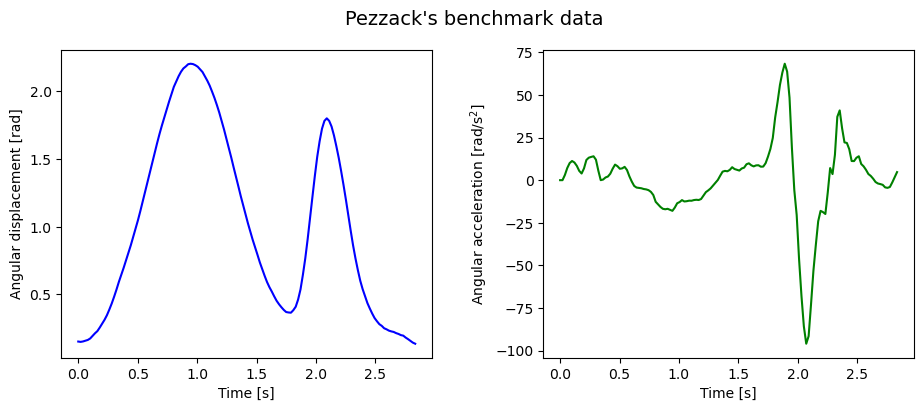

In [4]:
# load data file
# use Pandas just to read data from internet
data = pd.read_csv('https://raw.githubusercontent.com/BMClab/BMC/master/data/Pezzack.txt',
                   sep='\t', header=None, skiprows=6).to_numpy()
time, disp, disp2, aacc = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
dt = np.mean(np.diff(time))
# plot data
fig, (ax1,ax2) = plt.subplots(1, 2, sharex = True, figsize=(11, 4))
plt.suptitle("Pezzack's benchmark data", fontsize=14)
ax1.plot(time, disp, 'b')
ax1.set_xlabel('Time [s]'); ax1.set_ylabel('Angular displacement [rad]')
ax2.plot(time, aacc, 'g')
ax2.set_xlabel('Time [s]'); ax2.set_ylabel('Angular acceleration [rad/s$^2$]')
plt.subplots_adjust(wspace=0.3)

And using the residual analsysis code:

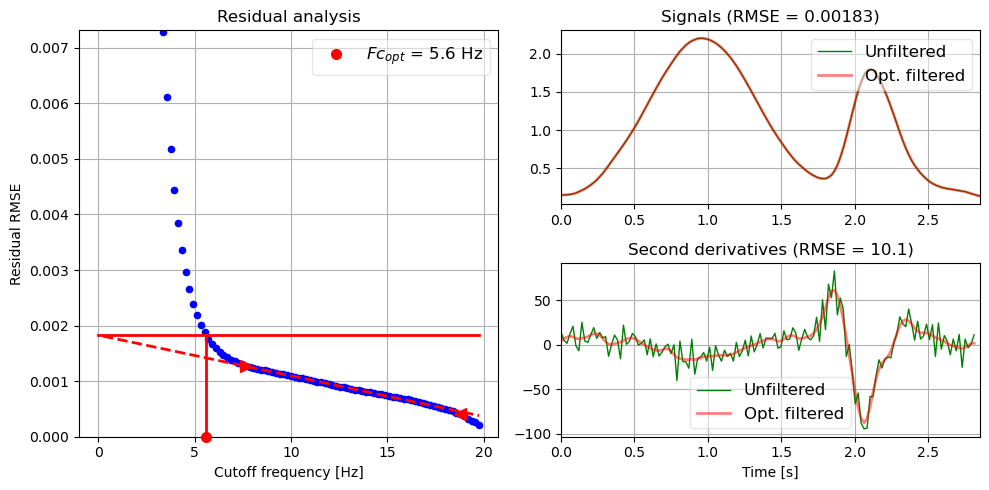

In [5]:
freq = np.mean(1/np.diff(time))
fc_opt = optcutfreq(disp, freq=freq, show=True)

The optimal cutoff frequency found is 5.6 Hz. Note that the filtering process is relevant only for the derivative of the data; we cannot distinguish the unfiltered and unfiltered displacements (see that the RMSE residual is very small).   
Let's employ this filter, differentiate the data twice and compare with the true acceleration as we did before:

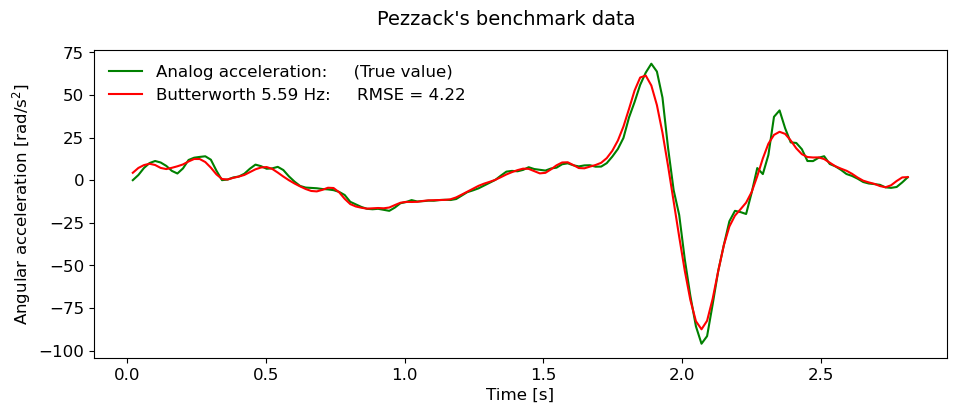

In [6]:
from scipy.signal import butter, filtfilt
# Butterworth filter
# Correct the cutoff frequency for the number of passes in the filter
C = 0.802 # for dual pass; C = (2**(1/npasses) - 1)**0.25
b, a = butter(2, (fc_opt/C)/(freq/2))
dispf = filtfilt(b, a, disp)
aaccBW =  np.diff(dispf, 2)*freq*freq
# RMSE:
rmseBW = np.sqrt(np.mean((aaccBW-aacc[1:-1])**2))
# plot data
fig, ax1 = plt.subplots(1, 1, figsize=(11, 4))
plt.suptitle("Pezzack's benchmark data", fontsize=14)
ax1.plot(time[1:-1], aacc[1:-1], 'g', label='Analog acceleration:     (True value)')
ax1.plot(time[1:-1], aaccBW, 'r',
         label='Butterworth %.3g Hz:     RMSE = %0.2f' %(fc_opt,rmseBW))
ax1.set_xlabel('Time [s]');
ax1.set_ylabel('Angular acceleration [rad/s$^2$]');
plt.legend(frameon=False, fontsize=12, loc='upper left');

The performance seems satisfactory (see [this Jupyter notebook](http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DataFiltering.ipynb) for a comparison using other filters), but it is known that this residual analysis algorithm results in oversmoothing the kinematic data (see  [http://www.clinicalgaitanalysis.com/faq/cutoff.html](http://www.clinicalgaitanalysis.com/faq/cutoff.html)).

To read more about the determination of the optimal cutoff frequency, see the following papers:  

- Pezzack, Norman, & Winter (1977). [An assessment of derivative determining techniques used for motion analysis](http://www.health.uottawa.ca/biomech/courses/apa7305/JB-Pezzack-Norman-Winter-1977.pdf). Journal of Biomechanics, 10, 377-382.
- Giakas & Baltizopoulos (1997) [A comparison of automatic filtering techniques applied to biomechanical walking data](http://www.pe.uth.gr/sk_cms/scriptlib/getblob.php?redir=../sk_cms/images/notfound.htm&table=pepublications&field=doc&id=30). J. Biomech. 30, 847-850.
- Alonso, Salgado, Cuadrado & Pintado (2009) [Automatic smoothing of raw kinematic signals using SSA and cluster analysis](http://lim.ii.udc.es/docs/proceedings/2009_09_EUROMECH_Automatic.pdf). 7th EUROMECH Solid Mechanics Conference.
- Kristianslund, Krosshaug & Bogert (2012) [Effect of low pass filtering on joint moments from inverse dynamics: Implications for injury prevention](http://www.klokavskade.no/upload/Publication/Kristianslund_2012_J%20Biomechan_Effect%20of%20low-pass%20filtering%20on%20joint%20moments%20from%20inverse%20dynamics.pdf). J. Biomech. 45, 666-671.

## References

- Pezzack JC, Norman RW, & Winter DA (1977). [An assessment of derivative determining techniques used for motion analysis](http://www.health.uottawa.ca/biomech/courses/apa7305/JB-Pezzack-Norman-Winter-1977.pdf). Journal of Biomechanics, 10, 377-382. [PubMed](http://www.ncbi.nlm.nih.gov/pubmed/893476).
- Winter DA (2009) [Biomechanics and motor control of human movement](http://books.google.com.br/books?id=_bFHL08IWfwC&printsec=frontcover&source=gbs_ge_summary_r&cad=0#v=onepage&q&f=false). 4 ed. Hoboken, EUA: Wiley.